# **Logistic Regression Classifier**

## Required Library Imports

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

## Data PreProcessing

In [2]:
# Load in data
train_data = pd.read_csv('train_dataset.csv')
test_data = pd.read_csv('test_dataset.csv')

# Load in Doc2Vec genre feature
train_D2V_genres = np.load('train_doc2vec_features_genre.npy')
test_D2V_genres = np.load('test_doc2vec_features_genre.npy')
pca = PCA(n_components = 10)
pca.fit(train_D2V_genres)
reduced_train_D2V_genres = pca.transform(train_D2V_genres)
reduced_test_D2V_genres = pca.transform(test_D2V_genres)

reduced_train_D2V_genres_df = pd.DataFrame(reduced_train_D2V_genres, columns=[f"doc2vec_genres_{i}" for i in range(reduced_train_D2V_genres.shape[1])])
reduced_test_D2V_genres_df = pd.DataFrame(reduced_test_D2V_genres, columns=[f"doc2vec_genres_{i}" for i in range(reduced_test_D2V_genres.shape[1])])

# Save id column for later Kaggle submission
id_col = test_data['id']
train_data = train_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

# Replace top 3 rated countries with ordered values 
def map_country(country):
    if country in high_rated_countries:
        if country == 'USA':
            return 3
        elif country == 'UK':
            return 2
        else:
            return 1
    else:
        return 0

high_rated_countries = ['USA', 'UK', 'France']
train_data['country'] = train_data['country'].map(map_country)
test_data['country'] = test_data['country'].map(map_country)

# Split into attributes and labels

attributes = train_data.iloc[:, :-1]
numeric_attributes = attributes.select_dtypes(include='number')
label = train_data.iloc[:, -1]

# Concatenate genre D2V to X and test data 
combined_train = pd.concat([numeric_attributes, reduced_train_D2V_genres_df, label], axis=1)
combined_train = combined_train.select_dtypes(include='number')

test_data = pd.concat([test_data, reduced_test_D2V_genres_df], axis=1)

# Remove missing values
combined_train.dropna(axis=0, inplace=True)



# Split combined data into X and y
X = combined_train.iloc[:, :-1]
y = combined_train.iloc[:, -1]

# Drop categorical/nominal data

corr_matrix = combined_train.corr()
corr_with_label = corr_matrix['imdb_score_binned'].sort_values(ascending=False)
corr_columns = corr_matrix.columns[abs(corr_matrix['imdb_score_binned']) > 0.1]
corr_columns = corr_columns.drop('imdb_score_binned')
X = X[corr_columns]
test_data = test_data[corr_columns]

## Tuning Model's Hyperparameters

In [3]:
# Define the pipeline for RF
pipeline = make_pipeline(StandardScaler(), LogisticRegression(solver='saga', random_state=42))

# Define the parameters grid to search for
param_grid = {
    'logisticregression__max_iter': [100, 5000, 10000],
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'logisticregression__penalty': ['l1', 'l2'],
}

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Print the best hyperparameters and the corresponding mean cross-validated score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'logisticregression__C': 10, 'logisticregression__max_iter': 5000, 'logisticregression__penalty': 'l1'}
Best Score: 0.6950709927897949


## Model Training and Evaluation

Cross Val accuracy: [0.70881864 0.69051581 0.69883527 0.68885191 0.68833333]
Cross Val Mean accuracy: 0.6950709927897949
Classification Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       0.31      0.02      0.03       235
           2       0.71      0.92      0.80      1839
           3       0.63      0.39      0.48       777
           4       0.83      0.64      0.72       129

    accuracy                           0.70      3004
   macro avg       0.49      0.39      0.41      3004
weighted avg       0.65      0.70      0.65      3004



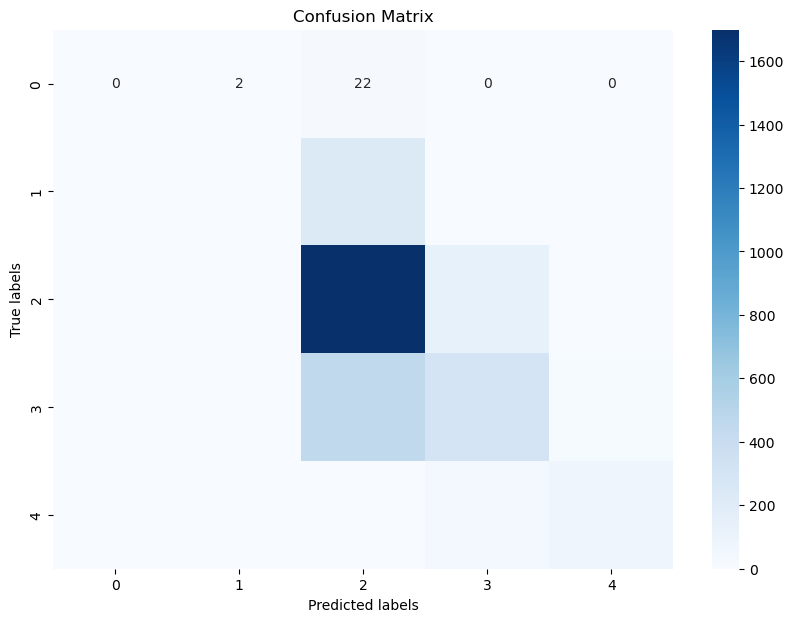

In [4]:
best_pipeline = grid_search.best_estimator_
cv_acc = cross_val_score(best_pipeline, X, y, cv=cv, scoring='accuracy')
cv_pred = cross_val_predict(best_pipeline, X, y, cv=cv)
print("Cross Val accuracy:", cv_acc)
print("Cross Val Mean accuracy:", cv_acc.mean())
print("Classification Report: \n", classification_report(y, cv_pred))
cm = confusion_matrix(y, cv_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Make Predictions

In [5]:
predictions = best_pipeline.predict(test_data)
predictions_df = pd.DataFrame({'id': id_col, 'imdb_score_binned': predictions})
predictions_df.to_csv('LogisticRegressionpredictions.csv', index=False)
